In [1]:
%cd ../../

/home/dmoreno/ATAT_ZTF/elasticc_one


In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np


import torch 
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#from utils import get_metrics, plot_values_times, plot_result_ablation, f1_values

# Evaluating performance over time

In [3]:
name_file_results = 'results_paper'

list_eval_time = ['0008', '0016', '0032', '0064', '0128', '0256', '0512', '1024', '2048']

In [5]:
data_root = 'data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_windows_200' 
data_root

'data/final/ZTF_ff/LC_MD_FEAT_v3_fixed_windows_200'

In [6]:
predictions = torch.load('results/ZTF/LC_MD_FEAT/{}/MTA/predictions_times.pt'.format('lc_md_feat_mta_v3_fixed_windows'))
predictions

FileNotFoundError: [Errno 2] No such file or directory: 'results/ZTF/LC_MD_FEAT/lc_md_feat_mta_v3_fixed_windows/MTA/predictions_times.pt'

In [6]:
predictions['list_y_pred_prob']['test_2048'].shape

(97746, 22)

In [7]:
predictions['list_y_pred_prob']['test_2048'][0].sum()

1.0000001

In [8]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = [i for i, snid in enumerate(snids_str) if snid.endswith("_0")]

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print(idx_windows_objects)
print('length: ', len(idx_unique_y_test))
print(idx_unique_y_test)

length:  8350
[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], [27, 28, 29, 30, 31, 32, 33, 34, 35], [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], [48, 49, 50, 51, 52, 53, 54, 55], [56, 57, 58, 59, 60, 61, 62, 63, 64], [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126], [127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141], [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153], [154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167], [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184], [185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197], [198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210], [211, 21

In [9]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = []
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([ 9, 11, 12, ...,  6,  0, 16]),
 'test_32': array([ 9,  4, 12, ...,  6, 20, 16]),
 'test_64': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_128': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_256': array([ 9, 11,  2, ...,  6,  6, 19]),
 'test_512': array([ 9, 11,  2, ...,  6,  6, 19]),
 'test_1024': array([ 9,  4, 12, ...,  6,  6, 19]),
 'test_2048': array([ 9, 11, 12, ...,  6,  6, 19])}

In [10]:
predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]
predictions['y_test_unique'].shape

torch.Size([8350])

In [11]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg', 'y_test_unique'])

# Paper results

In [12]:
import torch 

def get_metrics_window_avg(exp_name):
    predictions = torch.load('results/ZTF/{}/predictions_times.pt'.format(exp_name))
    
    snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]
    grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))
    idx_windows_objects = [list(group) for _, group in grouped]
    idx_unique_y_test = [i for i, snid in enumerate(snids_str) if snid.endswith("_0")]

    predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]

    predictions.update({
        'list_y_pred_prob_avg': dict(),
        'list_y_pred_avg': dict(),
        })

    for eval_time, predicciones in predictions['list_y_pred_prob'].items():
        predictions['list_y_pred_prob_avg'][eval_time] = []
        predictions['list_y_pred_avg'][eval_time] = [] 
        for idx_windows in idx_windows_objects:
            window_probs = predicciones[idx_windows]
            avg_probs = np.mean(window_probs, axis=0)
            predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
            predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

        predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
        predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])
        
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for set_type, y_pred in predictions['list_y_pred_avg'].items():
        y_pred = y_pred
        y_test = predictions['y_test_unique']
        f1_results_time[set_type] = f1_score(y_test, y_pred, average='macro')
        bacc_results_time[set_type] = balanced_accuracy_score(y_test, y_pred)
        acc_results_time[set_type] = accuracy_score(y_test, y_pred)
        precision_results_time[set_type] = precision_score(y_test, y_pred, average='macro')
        recall_results_time[set_type] = recall_score(y_test, y_pred, average='macro')

    return f1_results_time #, bacc_results_time, acc_results_time, precision_results_time, recall_results_time


def get_metrics_window_max(exp_name):
    predictions = torch.load('results/ZTF/{}/predictions_times.pt'.format(exp_name))
    
    snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]
    grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))
    idx_windows_objects = [list(group) for _, group in grouped]
    idx_unique_y_test = [i for i, snid in enumerate(snids_str) if snid.endswith("_0")]

    predictions['y_test_unique'] = predictions['y_test'][idx_unique_y_test]

    predictions.update({
        'list_y_pred_prob_avg': dict(),
        'list_y_pred_avg': dict(),
        })

    for eval_time, predicciones in predictions['list_y_pred_prob'].items():
        predictions['list_y_pred_prob_avg'][eval_time] = []
        predictions['list_y_pred_avg'][eval_time] = [] 
        for idx_windows in idx_windows_objects:
            window_probs = predicciones[idx_windows]
            max_probs = np.max(window_probs, axis=0)
            predictions['list_y_pred_prob_avg'][eval_time].append(max_probs)
            predictions['list_y_pred_avg'][eval_time].append(np.argmax(max_probs, axis=0))

        predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
        predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])
        
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for set_type, y_pred in predictions['list_y_pred_avg'].items():
        y_pred = y_pred
        y_test = predictions['y_test_unique']
        f1_results_time[set_type] = f1_score(y_test, y_pred, average='macro')
        bacc_results_time[set_type] = balanced_accuracy_score(y_test, y_pred)
        acc_results_time[set_type] = accuracy_score(y_test, y_pred)
        precision_results_time[set_type] = precision_score(y_test, y_pred, average='macro')
        recall_results_time[set_type] = recall_score(y_test, y_pred, average='macro')

    return f1_results_time #, bacc_results_time, acc_results_time, precision_results_time, recall_results_time



In [13]:
predictions = torch.load('results/ZTF/LC/{}/predictions_times.pt'.format('prueba_lc_v2_windows'))
predictions

dict_snid_windows = dict()
for snid in predictions['SNID']:
    split_item = snid.decode().split('_')
    snid, num_window = split_item[0], split_item[1]
    dict_snid_windows[snid] = num_window

list_snids = []
for key, value in dict_snid_windows.items():
    if value == '0':
        list_snids.append('{}_{}'.format(key, value).encode('utf-8'))
    else:
        list_snids.append('{}_{}'.format(key, int(value)-1).encode('utf-8'))
        
idx_to_use = np.array([np.where(predictions['SNID'] == b)[0][0] for b in list_snids])
len(idx_to_use)


8350

In [14]:
def get_metrics_window_last(exp_name):
    predictions = torch.load('results/ZTF/{}/predictions_times.pt'.format(exp_name))
    
    f1_results_time = dict()
    bacc_results_time = dict()
    acc_results_time = dict()
    precision_results_time = dict()
    recall_results_time = dict()
    for set_type, y_pred in predictions['list_y_pred'].items():
        y_pred = y_pred[idx_to_use]
        y_test = predictions['y_test'][idx_to_use]

        f1_results_time[set_type] = f1_score(y_test, y_pred, average='macro')
        bacc_results_time[set_type] = balanced_accuracy_score(y_test, y_pred)
        acc_results_time[set_type] = accuracy_score(y_test, y_pred)
        precision_results_time[set_type] = precision_score(y_test, y_pred, average='macro')
        recall_results_time[set_type] = recall_score(y_test, y_pred, average='macro')

    return f1_results_time 

In [15]:
def plot_values_times(list_eval_time, models_f1_results_time, title=None, 
                      ylim_min=0, ylim_max=90, colors=None, f1_added=None):
    fs = 17

    plt.figure(figsize=(8, 7))

    for name_model, f1_results_time in models_f1_results_time.items():

        list_f1_mean_fold = []
        for eval_time in list_eval_time:
            list_f1_mean_fold.append(f1_results_time['test_{}'.format(eval_time)]*100)

        print(list_f1_mean_fold)

        if name_model.find('MTA') != -1: 
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle='dashed')#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                list_f1_mean_fold + list_f1_std_fold, 
            #                list_f1_mean_fold - list_f1_std_fold, 
            #                alpha=0.4, color=colors[name_model])

        else:
            plt.plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model)#, color=colors[name_model])
            #plt.fill_between(np.log(list_eval_time)/np.log(2), 
            #                 list_f1_mean_fold + list_f1_std_fold, 
            #                 list_f1_mean_fold - list_f1_std_fold, 
            #                 alpha=0.5, color=colors[name_model])

            #plt.show()


    if f1_added is not None:
        plt.plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')
    
        plt.fill_between(np.log(list_eval_time)/np.log(2), 
                        f1_added['mean']*100 + f1_added['std']*100, 
                        f1_added['mean']*100 - f1_added['std']*100, 
                        alpha=0.4, color='#e41a1c')
            
    plt.yticks(fontsize=fs)
    plt.xticks(np.log(list_eval_time)/np.log(2), list_eval_time, fontsize=fs)

    plt.ylabel("F1-Score", fontsize=fs, labelpad=13)
    plt.xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

    plt.ylim((ylim_min, ylim_max))
    plt.legend(fontsize=fs) #, loc='lower right')

    #plt.savefig("all_curves_teval_a_last.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [39]:
f1_lc_mta_last = get_metrics_window_last(exp_name='LC/prueba_lc_mta_v2_windows/MTA')
f1_lc_mta_avg = get_metrics_window_avg(exp_name='LC/prueba_lc_mta_v2_windows/MTA')
f1_lc_mta_max = get_metrics_window_max(exp_name='LC/prueba_lc_mta_v2_windows/MTA')
f1_lc_mta_avg_err = get_metrics_window_avg(exp_name='LC/data_err_v2_windows/MTA')


f1_lc_md_feat_mta_last = get_metrics_window_last(exp_name='LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows_old/MTA')
f1_lc_md_feat_mta_avg = get_metrics_window_avg(exp_name='LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows_old/MTA')
f1_lc_md_feat_mta_max = get_metrics_window_max(exp_name='LC_MD_FEAT/prueba_lc_md_feat_mta_v2_windows_old/MTA')
f1_lc_md_feat_mta_avg_err = get_metrics_window_max(exp_name='LC_MD_FEAT/data_err_md_feat_mta_v2_windows/MTA')


In [45]:
list_eval_time = [16, 32, 64, 128, 256, 512, 1024, 2048]

models_f1_results_time = {
    'LC + MTA [last]': list(f1_lc_mta_last.values()),
    'LC + MTA [avg]': list(f1_lc_mta_avg.values()),
    'LC + MTA [max]': list(f1_lc_mta_max.values()),
    'LC + ERR + MTA [avg]': list(f1_lc_mta_avg_err.values()),
    'LC + MD + Features + MTA [last]': list(f1_lc_md_feat_mta_last.values()),
    'LC + MD + Features + MTA [avg]': list(f1_lc_md_feat_mta_avg.values()),
    'LC + MD + Features + MTA [max]': list(f1_lc_md_feat_mta_max.values()),
    'LC + ERR + MD + Features + MTA [avg]': list(f1_lc_md_feat_mta_avg_err.values()),
}#

colors = {
    'LC + MTA [last]': '#999999',
    'LC + MTA [avg]': '#ff7f00',
    'LC + MTA [max]': '#984ea3',
    'LC + ERR + MTA [avg]': '#17BECF',
    'LC + MD + Features + MTA [last]': '#999999', # '#17BECF',
    'LC + MD + Features + MTA [avg]': '#ff7f00', # '#4daf4a',
    'LC + MD + Features + MTA [max]': '#984ea3', # '#377eb8',
    'LC + ERR + MD + Features + MTA [avg]': '#17BECF', # '#377eb8',
}

In [46]:
#def f1_values(list_eval_time, models_f1_results_time):
#    dict_mean = dict()
#    dict_std = dict()
#
#    for name_model, f1_results_time in models_f1_results_time.items():
#
#        list_f1_mean_fold = []
#        list_f1_std_fold = []
#        for eval_time in list_eval_time:
#
#            f1_folds = []
#            for _, results in f1_results_time.items():
#                f1_folds.append(results['test_{}'.format(eval_time)])
#
#            list_f1_mean_fold.append(np.mean(f1_folds)*100)
#            list_f1_std_fold.append(np.std(f1_folds)*100)
#
#        list_f1_mean_fold = np.array(list_f1_mean_fold)
#        list_f1_std_fold = np.array(list_f1_std_fold)
#
#        dict_mean[name_model] = list_f1_mean_fold
#        dict_std[name_model] = list_f1_std_fold
#
#    return dict_mean, dict_std
#
#dict_mean, dict_std = f1_values(list_eval_time, models_f1_results_time)

In [47]:
order_models = [['LC + MTA [last]', 
                 'LC + MTA [avg]', 
                 'LC + MTA [max]', 
                 'LC + ERR + MTA [avg]'],

                ['LC + MD + Features + MTA [last]', 
                 'LC + MD + Features + MTA [avg]', 
                 'LC + MD + Features + MTA [max]',
                 'LC + ERR + MD + Features + MTA [avg]', ]
                 
                 ]

In [48]:
titles = ['(b) Light-curve only ATAT variants\n',
          '(d) Combined Light-curve and tabular\ndata ATAT variants']

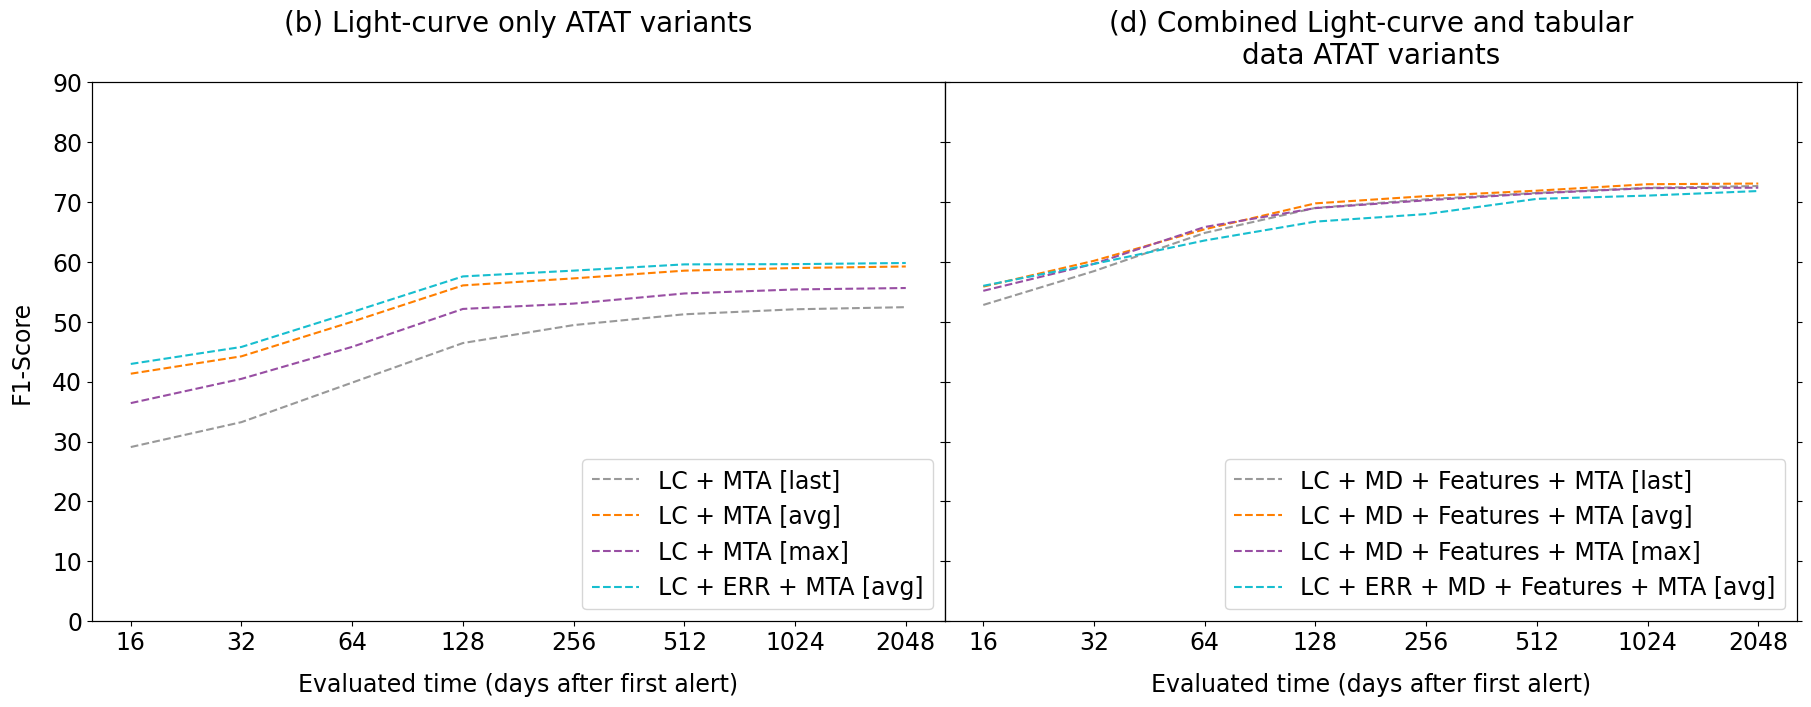

In [49]:
fs = 17
ylim_min = 0
ylim_max = 90


fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharey=True, gridspec_kw=dict(wspace=0))

for i, models_in_plot in enumerate(order_models):
    axes[i].set_title(titles[i], size=20, pad=13)

    for name_model in models_in_plot:
        list_f1_mean_fold = models_f1_results_time[name_model]
        #list_f1_std_fold = models_f1_results_time[name_model]

        if name_model.find('MTA') != -1:
            linestyle='dashed'
        else:
            linestyle='-'

        axes[i].plot(np.log(list_eval_time)/np.log(2), np.array(list_f1_mean_fold)*100, label=name_model, linestyle=linestyle, color=colors[name_model])
    
        #axes[i].fill_between(np.log(list_eval_time)/np.log(2), 
        #                     list_f1_mean_fold + list_f1_std_fold, 
        #                     list_f1_mean_fold - list_f1_std_fold, 
        #                     alpha=0.4, color=colors[name_model])

        axes[i].tick_params(axis="y", labelsize=fs) 
        axes[i].set_xticks(np.log(list_eval_time)/np.log(2)) 
        axes[i].set_xticklabels(list_eval_time, fontsize=fs)

        if i == 0: axes[i].set_ylabel("F1-Score", fontsize=fs, labelpad=13)
        axes[i].set_xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

        axes[i].set_ylim((ylim_min, ylim_max))
        axes[i].legend(fontsize=fs, loc='lower right')

    ax_right = axes[i].twinx()
    ax_right.tick_params(axis="y", labelright=False, labelsize=fs)
    ax_right.set_ylim(ylim_min, ylim_max)
    #ax_right.set_yticks([])

#axes[1].plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')
#
#axes[1].fill_between(np.log(list_eval_time)/np.log(2), 
#                f1_added['mean']*100 + f1_added['std']*100, 
#                f1_added['mean']*100 - f1_added['std']*100, 
#                alpha=0.4, color='#e41a1c')

axes[1].legend(fontsize=fs, loc='lower right')

#plt.savefig("all_curves_teval_b_c_d_last.pdf", format="pdf", bbox_inches="tight")
plt.show()

[5.5924488833089825, 7.974271569684734, 12.309613086808602, 16.10451957252426, 24.517315010749293, 33.492402182086785, 44.520016700434724, 53.92589078814303]
[22.331195537642785, 25.90002154982059, 29.63474621528392, 34.60279094489416, 41.538747588262886, 48.457959564526085, 55.23797173096606, 62.91383546352202]
[49.943777617947966, 52.72125854212915, 55.77067905515057, 57.57626630625163, 60.11037187722438, 62.938131376344316, 67.50386430455049, 69.98862450081748]
[18.26266596394235, 20.04075232502419, 25.50441326568855, 40.59637549542552, 38.27818047073812, 41.6986181438052, 45.83297179951353, 52.28662841675145]
[46.39704331734238, 45.47328393361352, 48.56133421387034, 56.854457021033966, 56.1472958591285, 58.27728842677226, 61.10438379479375, 63.339467629703364]


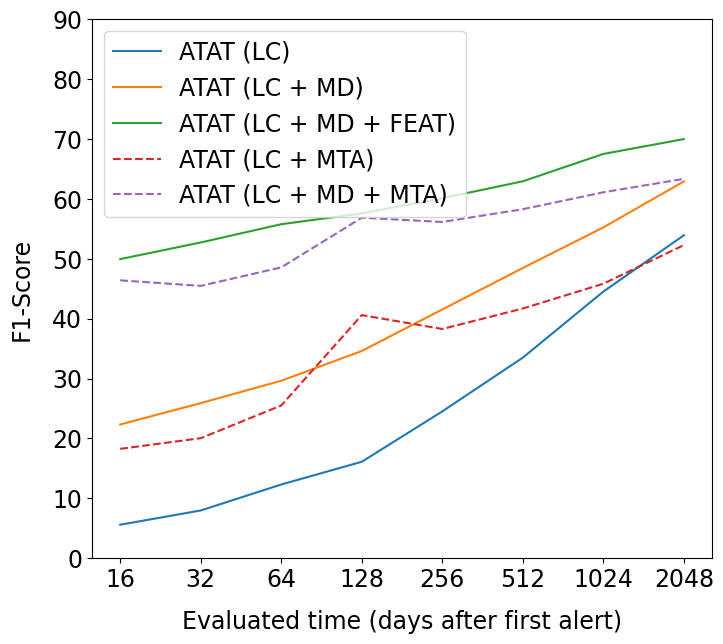

In [17]:
list_eval_time = [16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MD)': f1_lc_md,
    'ATAT (LC + MD + FEAT)': f1_lc_md_feat,

    'ATAT (LC + MTA)': f1_lc_mta,
    'ATAT (LC + MD + MTA)': f1_lc_md_mta,
}

plot_values_times(list_eval_time, models_f1_results_time)

In [68]:
f1_lc = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200', clf_type='lc')
f1_lc_over = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_oversampling', clf_type='lc')
f1_lc_window = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_window', clf_type='lc')
f1_lc_g = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_g', clf_type='lc')
f1_lc_r = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_r', clf_type='lc')
f1_lc_md = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_lc_md1', clf_type='mix')

[3.6096576701300584, 4.446612065450422, 5.59620910816614, 9.619080935457847, 16.789848613750898, 23.47858221980553, 30.2437932377458, 42.88506578989324, 54.50033181872307]
[3.4511918482397, 4.860536846671353, 7.881198716577805, 12.417720106392517, 18.3328867830215, 22.537778363394565, 29.243693445343965, 41.2204248419813, 53.50175102785734]
[18.311734588613895, 22.52874969824704, 28.164580887117307, 34.819763322635126, 40.510609323124136, 45.78364248827594, 50.544834347933055, 51.40599496164916, 51.70746151165714]
[4.5513253867459, 4.8438458240259585, 5.95575759061399, 9.566691165762796, 12.43009848425896, 15.587110203415985, 23.3325851111872, 38.65062300068646, 50.402740031555695]
[2.7038300894311087, 3.2394370271609914, 5.656535932284865, 9.125071740129574, 12.147588848888823, 17.940365326511753, 22.93971651094173, 34.67239106058197, 49.050166496192595]
[25.734524495531158, 27.649349568692017, 30.92672363075294, 35.328808061219846, 43.244009812326674, 47.372187088878825, 52.026043268

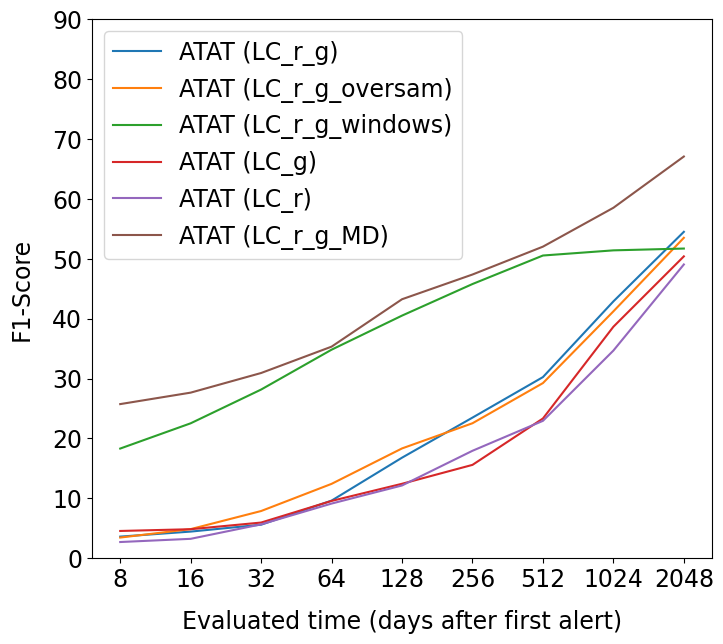

In [72]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC_r_g)': f1_lc,
    'ATAT (LC_r_g_oversam)': f1_lc_over,
    'ATAT (LC_r_g_windows)': f1_lc_window,
    'ATAT (LC_g)': f1_lc_g,
    'ATAT (LC_r)': f1_lc_r,

    'ATAT (LC_r_g_MD)': f1_lc_md,
}

plot_values_times(list_eval_time, models_f1_results_time):

In [ ]:
f1_lc = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200', clf_type='lc')
f1_lc_over = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_oversampling', clf_type='lc')
f1_lc_window = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_window', clf_type='lc')
f1_lc_g = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_g', clf_type='lc')
f1_lc_r = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_band_r', clf_type='lc')
f1_lc_md = get_metrics(exp_name='epoch1000_patience30_lr1e-4_MAX200_lc_md1', clf_type='mix')

In [ ]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

In [ ]:
for set_type, batches_pred in dict_pred_times.items():
    f1_results_time['fold_{}'.format(i)][set_type] = f1_score(target, 
                                                                np.argmax(batches_pred, axis = 1), 
                                                                average='macro')

In [6]:
f1_lc_header_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_lc_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime-seed=*'.format(name_file_results))

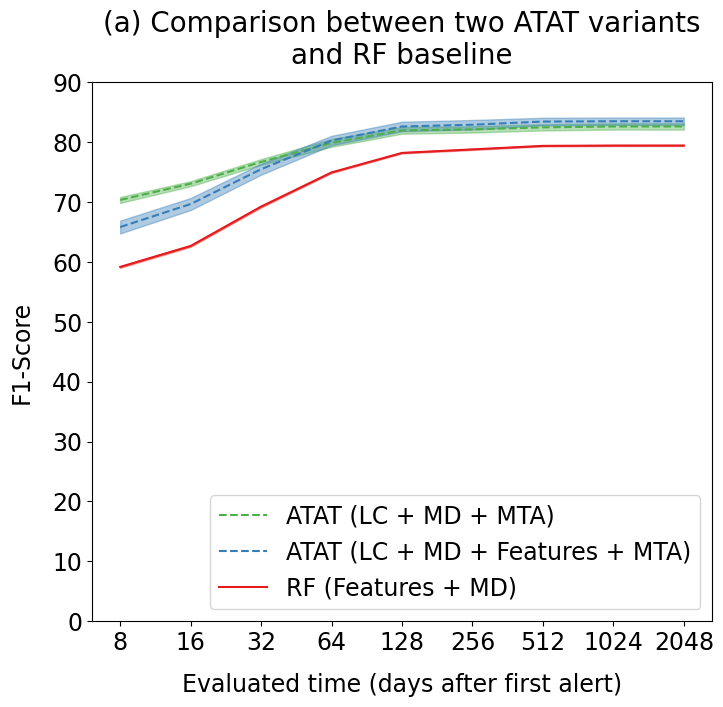

In [7]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

title = '(a) Comparison between two ATAT variants\nand RF baseline'
plot_values_times(list_eval_time, models_f1_results_time, title, colors=colors, f1_added=f1_added)

## Plot 1

In [8]:
f1_lc, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc-seed=*'.format(name_file_results))
f1_lc_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc_mtime-seed=*'.format(name_file_results))

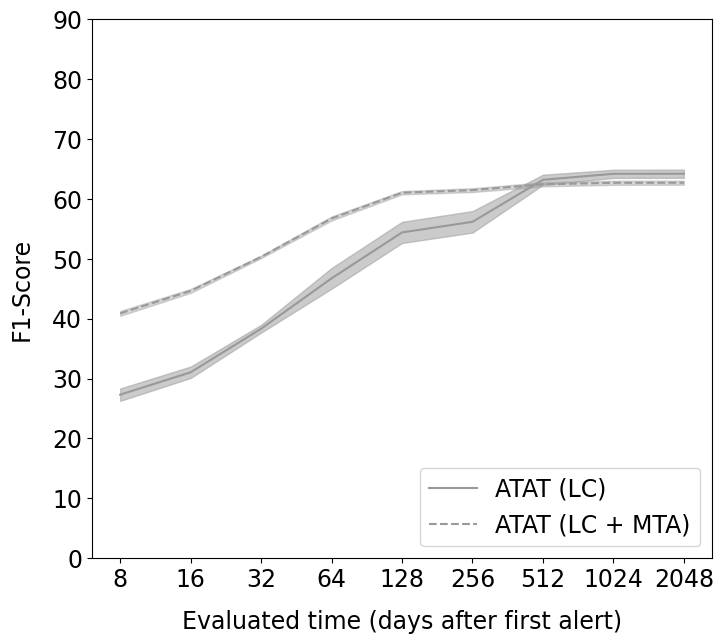

In [9]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

## Plot 2

In [10]:
f1_features, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=features-seed=*'.format(name_file_results))
f1_features_mtime, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=features_mtime-seed=*'.format(name_file_results))
f1_header_feat, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header_feat-seed=*'.format(name_file_results))
f1_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header_feat_mtime-seed=*'.format(name_file_results))
f1_header, _, _, _ = get_metrics(list_path_predictions='{}/tab/Exp_cfg_-arch=header-seed=*'.format(name_file_results))

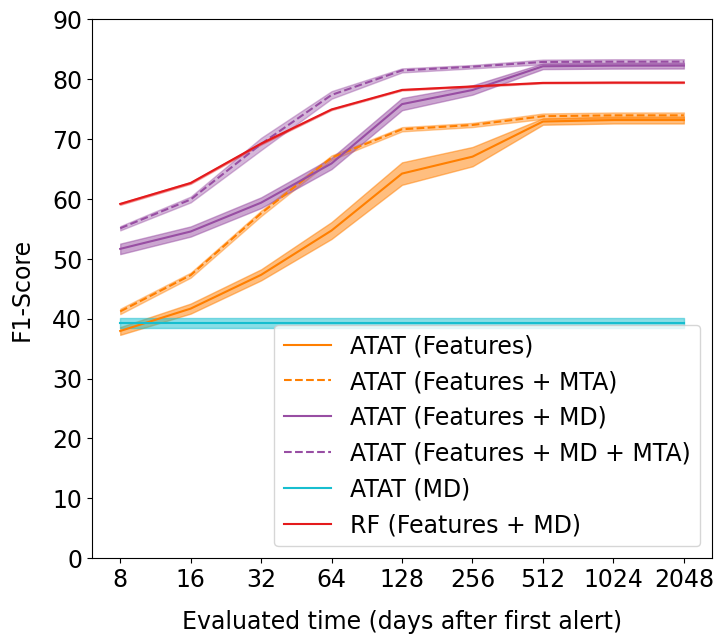

In [11]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (Features)': f1_features,
    'ATAT (Features + MTA)': f1_features_mtime,
    'ATAT (Features + MD)': f1_header_feat,
    'ATAT (Features + MD + MTA)': f1_header_feat_mtime,
    'ATAT (MD)': f1_header,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors, f1_added=f1_added)

## Plot 3

In [12]:
f1_lc_header, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header-seed=*'.format(name_file_results))
f1_lc_header_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_lc_header_feat, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat-seed=*'.format(name_file_results))
f1_lc_header_feat_mtime, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_feat_mtime-seed=*'.format(name_file_results))

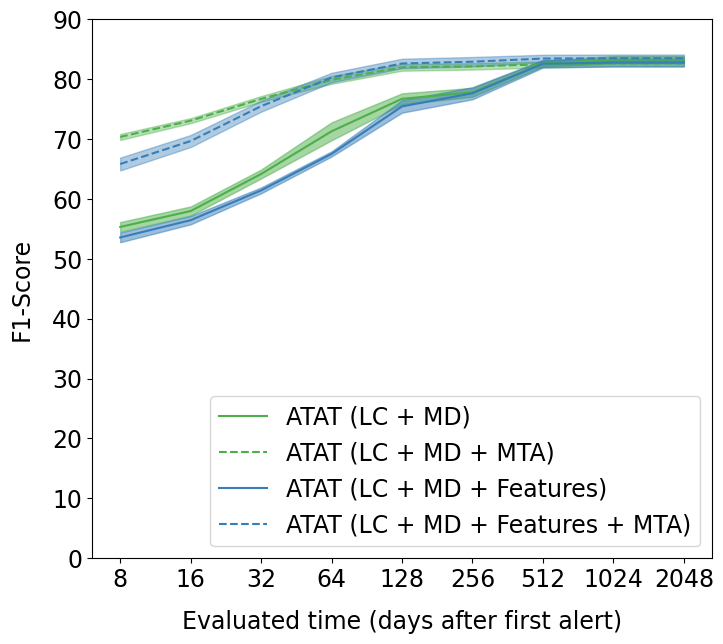

In [13]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
models_f1_results_time = {
    'ATAT (LC + MD)': f1_lc_header,
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features)': f1_lc_header_feat,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

plot_values_times(list_eval_time, models_f1_results_time, colors=colors)

## Joint plot

In [14]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

models_f1_results_time = {
    'ATAT (LC)': f1_lc,
    'ATAT (LC + MTA)': f1_lc_mtime,
    'ATAT (Features)': f1_features,
    'ATAT (Features + MTA)': f1_features_mtime,
    'ATAT (Features + MD)': f1_header_feat,
    'ATAT (Features + MD + MTA)': f1_header_feat_mtime,
    'ATAT (MD)': f1_header,
    'ATAT (LC + MD)': f1_lc_header,
    'ATAT (LC + MD + MTA)': f1_lc_header_mtime,
    'ATAT (LC + MD + Features)': f1_lc_header_feat,
    'ATAT (LC + MD + Features + MTA)': f1_lc_header_feat_mtime,
}

In [15]:
dict_mean, dict_std = f1_values(list_eval_time, models_f1_results_time)

In [16]:
order_models = [['ATAT (LC)', 'ATAT (LC + MTA)'], 
                ['ATAT (Features)', 'ATAT (Features + MTA)', 'ATAT (Features + MD)', 'ATAT (Features + MD + MTA)', 'ATAT (MD)'],
                ['ATAT (LC + MD)', 'ATAT (LC + MD + MTA)', 'ATAT (LC + MD + Features)', 'ATAT (LC + MD + Features + MTA)']]

In [17]:
titles = ['(b) Light-curve only ATAT variants\n',
          '(c) Tabular data only ATAT variants\nplus RF baseline',
          '(d) Combined Light-curve and tabular\ndata ATAT variants']

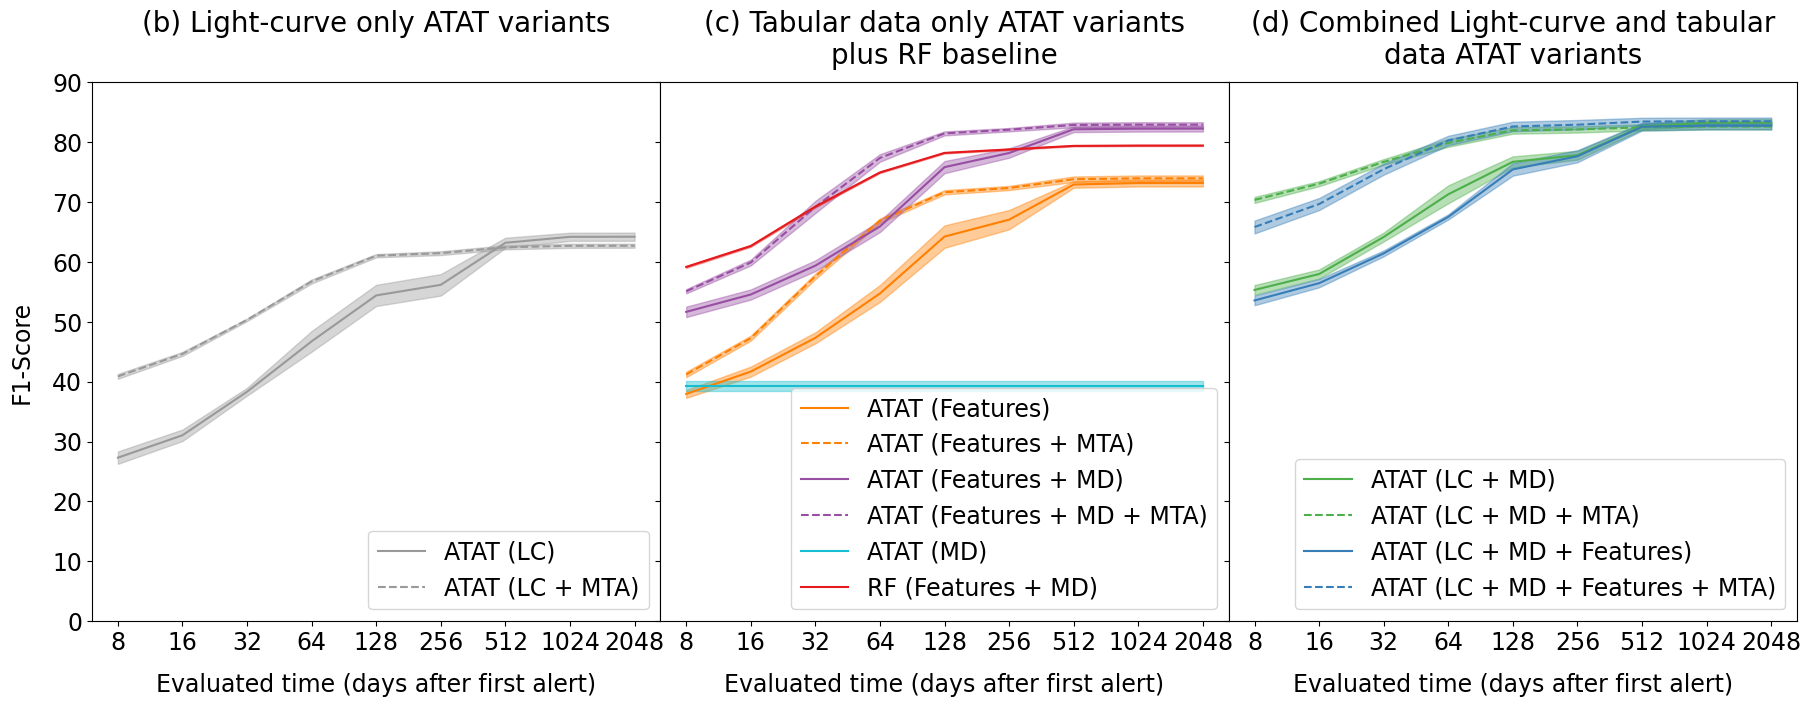

In [18]:
fs = 17
ylim_min = 0
ylim_max = 90


fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True, gridspec_kw=dict(wspace=0))

for i, models_in_plot in enumerate(order_models):
    axes[i].set_title(titles[i], size=20, pad=13)

    for name_model in models_in_plot:
        list_f1_mean_fold = dict_mean[name_model]
        list_f1_std_fold = dict_std[name_model]

        if name_model.find('MTA') != -1:
            linestyle='dashed'
        else:
            linestyle='-'

        axes[i].plot(np.log(list_eval_time)/np.log(2), list_f1_mean_fold, label=name_model, linestyle=linestyle, color=colors[name_model])
    
        axes[i].fill_between(np.log(list_eval_time)/np.log(2), 
                             list_f1_mean_fold + list_f1_std_fold, 
                             list_f1_mean_fold - list_f1_std_fold, 
                             alpha=0.4, color=colors[name_model])

        axes[i].tick_params(axis="y", labelsize=fs) 
        axes[i].set_xticks(np.log(list_eval_time)/np.log(2)) 
        axes[i].set_xticklabels(list_eval_time, fontsize=fs)

        if i == 0: axes[i].set_ylabel("F1-Score", fontsize=fs, labelpad=13)
        axes[i].set_xlabel("Evaluated time (days after first alert)", fontsize=fs, labelpad=13)

        axes[i].set_ylim((ylim_min, ylim_max))
        axes[i].legend(fontsize=fs, loc='lower right')

axes[1].plot(np.log(list_eval_time)/np.log(2), f1_added['mean']*100, label='RF (Features + MD)', linestyle='-', color='#e41a1c')

axes[1].fill_between(np.log(list_eval_time)/np.log(2), 
                f1_added['mean']*100 + f1_added['std']*100, 
                f1_added['mean']*100 - f1_added['std']*100, 
                alpha=0.4, color='#e41a1c')

axes[1].legend(fontsize=fs, loc='lower right')

#plt.savefig("all_curves_teval_b_c_d_last.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Ablation study

In [19]:
f1_tm_lc, _, _, _ = get_metrics(list_path_predictions='{}/lc/Exp_cfg_-arch=lc_mtime-seed=*'.format(name_file_results))
f1_pe_lc, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_pos_enc_mtime-seed=*'.format(name_file_results))

f1_tm_lc_md, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_mtime_no_qt-seed=*'.format(name_file_results))
f1_pe_lc_md, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_pos_enc_mtime_no_qt-seed=*'.format(name_file_results))

f1_tm_lc_md_qt, _, _, _ = get_metrics(list_path_predictions='{}/lc_tab/Exp_cfg_-arch=lc_header_mtime-seed=*'.format(name_file_results))
f1_pe_lc_md_qt, _, _, _ = get_metrics(list_path_predictions='{}/ablation/Exp_cfg_-arch=lc_header_pos_enc_mtime-seed=*'.format(name_file_results))

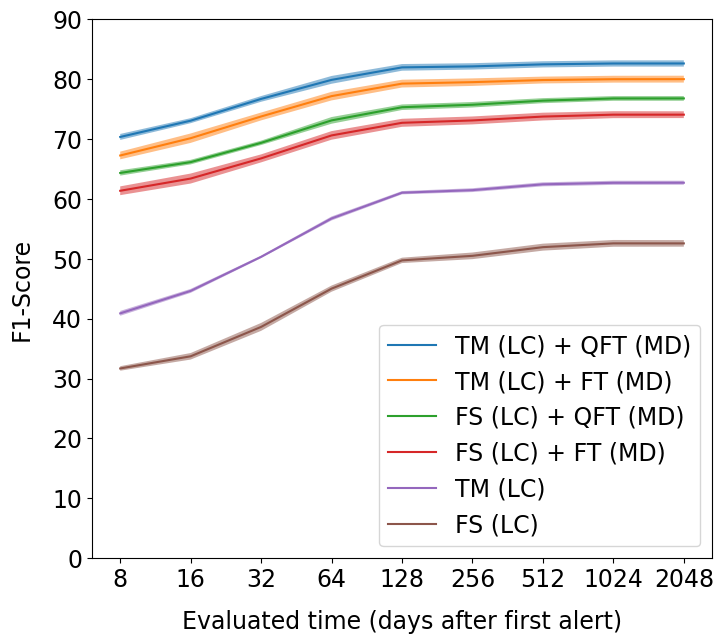

In [20]:
list_eval_time = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

models_f1_results_time = {
    'TM (LC) + QFT (MD)': f1_tm_lc_md_qt,
    'TM (LC) + FT (MD)': f1_tm_lc_md,
    'FS (LC) + QFT (MD)': f1_pe_lc_md_qt,
    'FS (LC) + FT (MD)': f1_pe_lc_md,
    'TM (LC)': f1_tm_lc,
    'FS (LC)': f1_pe_lc,
}

plot_result_ablation(list_eval_time, models_f1_results_time)